# Pull Request Features

プルリクエストの特徴量とバグ混入の有無の関係を調べる。

### バグ混入の有無でプルリクエストの特徴量に差があるかを検定

In [3]:
import numpy as np
import polars as pl
from scipy.stats import chi2_contingency, mannwhitneyu

pl.Config(tbl_rows=20)
EXCLUDE_COLUMNS = ["project", "id", "url", "buggy"]


# プルリクエストの特徴量データを読み込み, バグの有無でデータを分割
df = (
    pl.read_csv("data/pull_request_features.csv")
    .filter(pl.col("bot") == False)
    .drop("bot")
)
buggy_df = df.filter(pl.col("buggy") == True)
non_buggy_df = df.filter(pl.col("buggy") == False)
df = df.drop(EXCLUDE_COLUMNS)

print(f"# of buggy    : {buggy_df.height}")
print(f"# of non-buggy: {non_buggy_df.height}")

# 出力用データフレームの初期化
output_df = pl.DataFrame()

# 数値特徴量に対して Mann-Whitney U検定を実行
numeric_columns = df.select(pl.col(pl.Float64), pl.col(pl.Int64)).columns
for feature in numeric_columns:
    buggy_values = buggy_df[feature]
    non_buggy_values = non_buggy_df[feature]

    # Mann-Whitney U検定
    stat, p = mannwhitneyu(buggy_values, non_buggy_values)
    r = stat / (buggy_values.len() * non_buggy_values.len())

    # 結果
    output_df = output_df.vstack(
        pl.DataFrame(
            {
                "feature": [feature],
                "test": ["Mann-Whitney U"],
                "stat": [stat],
                "p": [p],
                "significant": [p < 0.05],
                "effect_size": r,
                "mean(buggy)": [buggy_values.mean()],
                "mean(non-buggy)": [non_buggy_values.mean()],
                "median(buggy)": [buggy_values.median()],
                "median(non-buggy)": [non_buggy_values.median()],
            }
        )
    )

# 真偽値特徴量に対してカイ二乗検定を実行
boolean_columns = df.select(pl.col(pl.Boolean)).columns
for feature in boolean_columns:
    buggy_values = buggy_df[feature].to_numpy()
    non_buggy_values = non_buggy_df[feature].to_numpy()

    # カイ二乗検定
    contigency_table = np.array(
        [
            [sum(buggy_values), sum(~buggy_values)],
            [sum(non_buggy_values), sum(~non_buggy_values)],
        ]
    )
    stat, p, dof, expected = chi2_contingency(contigency_table)
    cramer_v = (stat / contigency_table.sum()) ** 0.5

    # 結果
    output_df = output_df.vstack(
        pl.DataFrame(
            {
                "feature": feature,
                "test": "Chi-Square",
                "stat": stat,
                "p": p,
                "significant": p < 0.05,
                "effect_size": cramer_v,
                "mean(buggy)": buggy_values.mean(),
                "mean(non-buggy)": non_buggy_values.mean(),
                "median(buggy)": np.median(buggy_values),
                "median(non-buggy)": np.median(non_buggy_values),
            }
        )
    )
display(output_df)

# of buggy    : 888
# of non-buggy: 5489


feature,test,stat,p,significant,effect_size,mean(buggy),mean(non-buggy),median(buggy),median(non-buggy)
str,str,f64,f64,bool,f64,f64,f64,f64,f64
"""age""","""Mann-Whitney U""",2667530.5,0.000006,true,0.547272,24359.237969,22198.516658,5393.891667,3918.15
"""#commits""","""Mann-Whitney U""",3210565.5,7.8554e-71,true,0.658681,6.727477,2.347604,2.0,1.0
"""#added""","""Mann-Whitney U""",3682074.5,2.8256e-132,true,0.755416,2421.442568,444.028785,243.5,27.0
"""#deleted""","""Mann-Whitney U""",3.448654e6,2.5653e-88,true,0.707528,793.309685,339.576972,46.0,7.0
"""#files""","""Mann-Whitney U""",3.590232e6,3.1612e-118,true,0.736574,32.626126,10.649116,9.0,2.0
"""#comments""","""Mann-Whitney U""",2.585994e6,0.002573,true,0.530544,3.934685,2.547276,1.0,1.0
"""#review_comments""","""Mann-Whitney U""",2659721.5,4.2192e-16,true,0.54567,2.411036,0.817089,0.0,0.0
"""#approvals""","""Mann-Whitney U""",2329146.5,0.001886,true,0.477849,0.210586,0.248315,0.0,0.0
"""#changes_requested""","""Mann-Whitney U""",2.499499e6,0.000002,true,0.512799,0.067568,0.025506,0.0,0.0


### ロジスティック

In [28]:
import numpy as np
import polars as pl
import statsmodels.api as sm

EXCLUDE_COLUMNS = ["project", "id", "url", "bot"]

# プルリクエストの特徴量データを読み込み
df = (
    pl.read_csv("data/pull_request_features.csv")
    .filter(pl.col("bot") == False)
    .drop(EXCLUDE_COLUMNS)
)

# ロジスティック回帰分析
X = df.drop("buggy").to_pandas()
X = sm.add_constant(X)
display(X)
y = df["buggy"].to_numpy()
model = sm.Logit(y, X.astype(float))
result = model.fit()
print(result.summary())

,const,age,#commits,#added,#deleted,#files,#comments,#review_comments,same_repository,#approvals,#changes_requested,fix,test
0,1.0,1549.416667,1,37,0,2,2,0,False,1,0,False,True
1,1.0,2534.666667,1,146,0,1,0,0,False,0,0,True,True
2,1.0,15821.316667,9,255,21,9,8,7,False,0,0,True,True
3,1.0,73.466667,5,168,64,6,0,0,True,0,0,True,True
4,1.0,21.383333,2,2,1,2,1,0,False,0,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6372,1.0,6288.233333,2,36,459,23,2,0,False,0,0,False,True
6373,1.0,6030.416667,1,9,3,1,1,0,False,0,0,False,False
6374,1.0,4973.133333,10,378,38,7,4,0,False,0,0,False,True
6375,1.0,7738.633333,1,1,2,1,3,0,False,0,0,False,False


Optimization terminated successfully.
         Current function value: 0.373498
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6377
Model:                          Logit   Df Residuals:                     6364
Method:                           MLE   Df Model:                           12
Date:                Thu, 23 Jan 2025   Pseudo R-squ.:                 0.07458
Time:                        16:12:08   Log-Likelihood:                -2381.8
converged:                       True   LL-Null:                       -2573.8
Covariance Type:            nonrobust   LLR p-value:                 9.548e-75
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.6463      0.073    -36.206      0.000      -2.790      -2.503
age  

### 各特徴量の箱ひげ図 (一応)

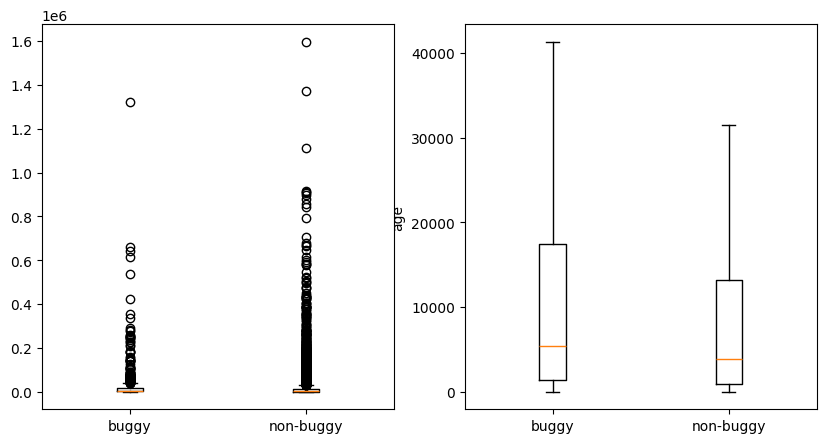

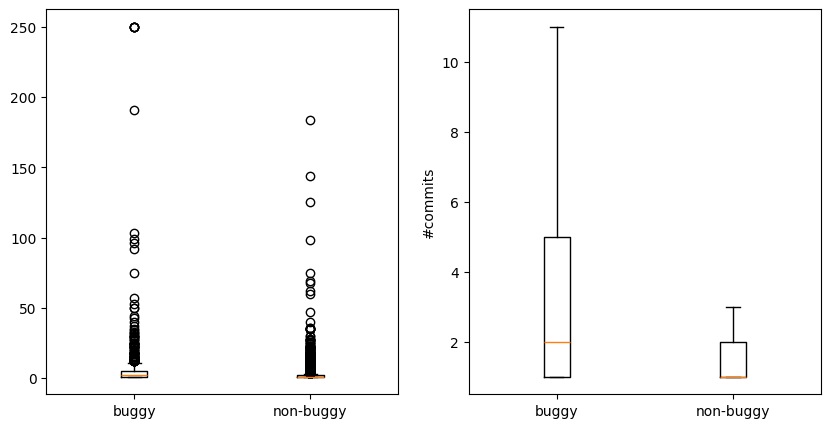

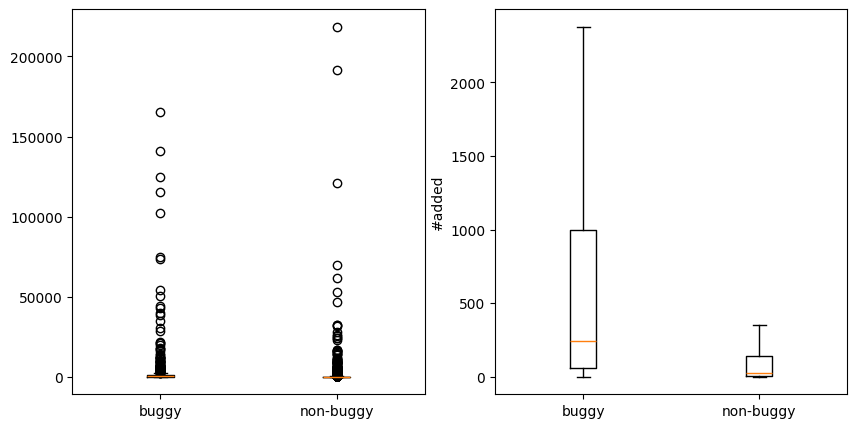

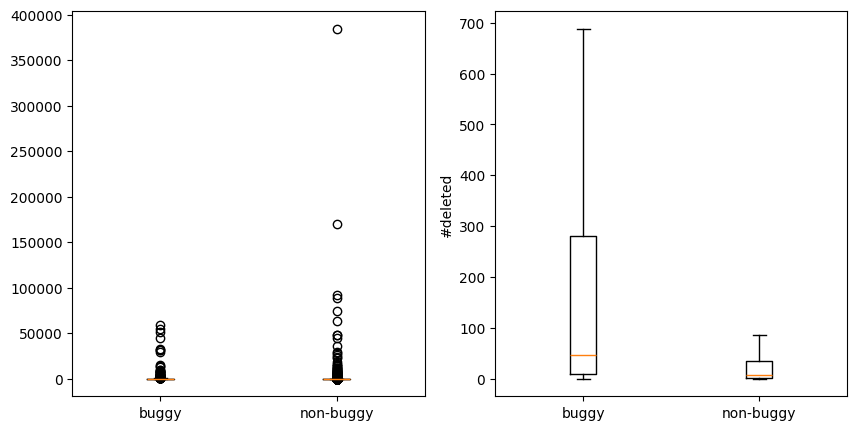

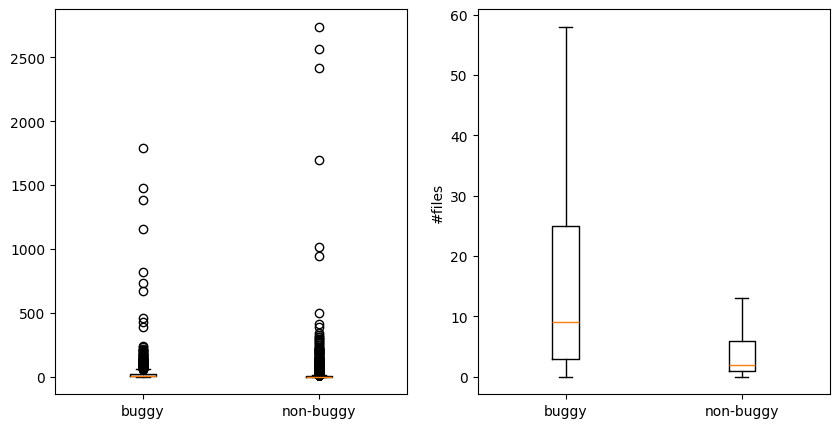

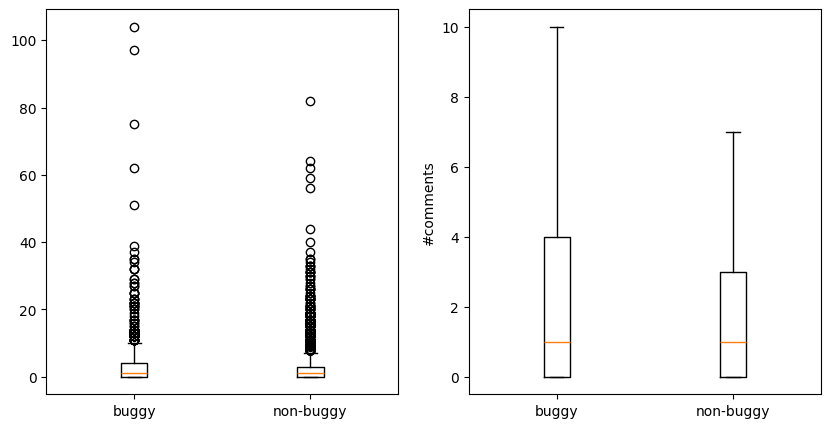

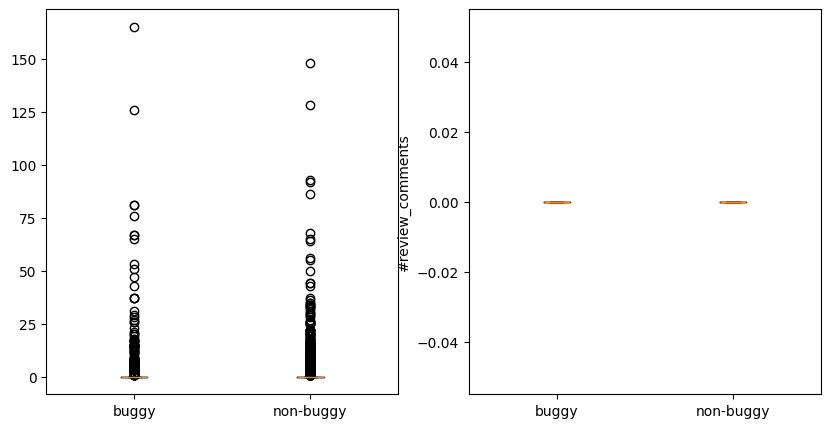

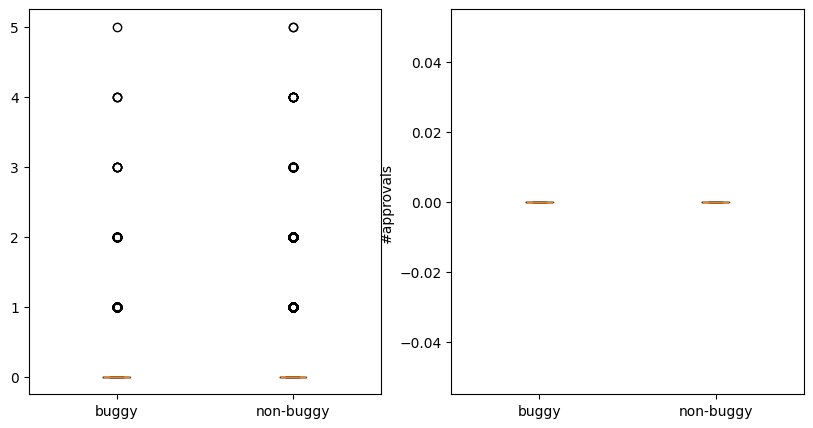

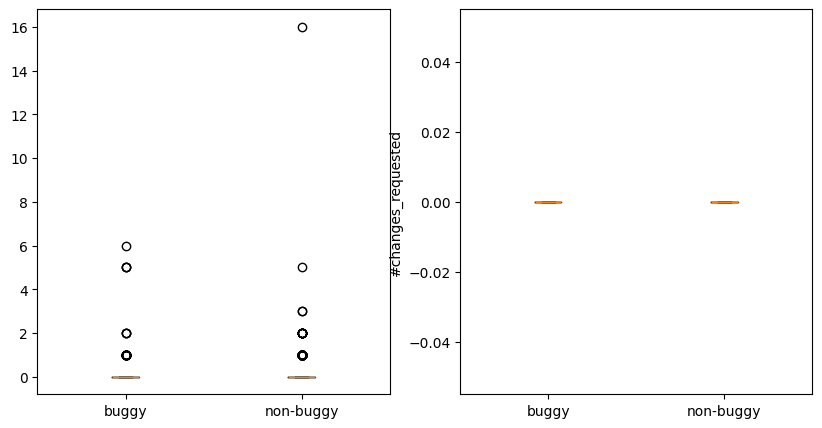

In [11]:
import matplotlib.pyplot as plt
import polars as pl

EXCLUDE_COLUMNS = ["project", "id", "url", "buggy"]

# プルリクエストの特徴量データを読み込み
df = (
    pl.read_csv("data/pull_request_features.csv")
    .filter(pl.col("bot") == False)
    .drop("bot")
)

# バグの有無でデータを分割
buggy_df = df.filter(pl.col("buggy") == True)
non_buggy_df = df.filter(pl.col("buggy") == False)
df = df.drop(EXCLUDE_COLUMNS)
numeric_columns = df.select(pl.col(pl.Float64), pl.col(pl.Int64)).columns
boolean_columns = df.select(pl.col(pl.Boolean)).columns

# 数値特徴量の分布を可視化
for feature in numeric_columns:
    buggy_values = buggy_df[feature]
    non_buggy_values = non_buggy_df[feature]

    # 箱ひげ図にプロット
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].boxplot(
        [buggy_values, non_buggy_values],
        tick_labels=["buggy", "non-buggy"],
        showfliers=True,
    )
    ax[1].boxplot(
        [buggy_values, non_buggy_values],
        tick_labels=["buggy", "non-buggy"],
        showfliers=False,
    )
    plt.ylabel(f"{feature}")
    plt.show()